# Face Detection using MTCNN(Multi-task Cascaded Convolutional Networks)

In this notebook, we use MTCNN for face detection and alignment.   

Reference:   
[MTCNN paper](https://arxiv.org/abs/1604.02878)  
[MTCNN github](https://github.com/ShyBigBoy/face-detection-mtcnn)


##  MTCNN

Given an image, MTCNN initially resize it to different scales to build an image pyramid, which is the input of the following three-stage cascaded framework:

-Stage 1 (P-NEt):  exploit a fully convolutional network, called Proposal Network (P-Net), to obtain the candidate windows. Then we use the estimated bounding box regression vectors to calibrate the candidates. After that, MTCNN employ non-maximum suppression (NMS) to merge highly overlapped candidates.

-Stage 2 (R-Net):  all candidates are fed to another CNN, called Refine Network (R-Net), which further rejects a large number of false candidates, performs calibration with bounding box regression, and NMS candidate merge.

-Stage 3 (O-Net):  This stage is similar to the second stage, but in this stage MTCNN aim to describe the face in more details. In particular, the network will output five facial landmarks’ positions.  
  
![1](1.png)  
![2](2.jpg)

## Clone MTCNN from Github

Execute the following command in Anaconda prompt to clone MTCNN from Github.  
  
git clone https://github.com/ShyBigBoy/face-detection-mtcnn.git  
cd face-detection-mtcnn  
jupyter notebook

## File Path

face_detection_MTCNN  
├── face_detection_MTCNN.ipynb   
├── det1.npy    
├── det2.npy  
├── det3.npy  
├── detect_face.py  
└── data  
........├── images             (  folder for testing images  )   
........└── videos             (  folder for testing videos  )

## Step 1 

Load the packages.

In [1]:
# ignore the warning
import warnings
warnings.filterwarnings('ignore')

# packages about Utilities
import os
import sys
import random
from tqdm import tqdm
from scipy import misc

# pacakges about image processing
import cv2
import matplotlib.pyplot as plt

# tensorflow
import tensorflow as tf

# package of detect_face
import detect_face

Set the parameters.

In [2]:
# root directory of the project
ROOT_DIR = os.getcwd()

# path of data
DATA_PATH = os.path.join(ROOT_DIR, "data")

# path of testing-image folder
TEST_IMGS_PATH = os.path.join(DATA_PATH, "images")

#  path of testing-video folder
TEST_VIDEOS_PATH = os.path.join(DATA_PATH, "videos")

Set the network parameters.

In [3]:
# minimum size of face
minsize = 20 
# the threshold of the 3 network (P-Net, R-Net, O-Net)
threshold = [ 0.6, 0.7, 0.7 ]  
# scale factor
factor = 0.709 

#gpu memory fraction
gpu_memory_fraction=1.0

## Step 2

Build MTCNN network architecture.

In [4]:
# print out what we do now
print('Creating networks and loading parameters')

# this MTCNN is ctreated with Tensorflow, so we execute it with Tensorflow
with tf.Graph().as_default():
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_memory_fraction)
        sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
        with sess.as_default():
            pnet, rnet, onet = detect_face.create_mtcnn(sess, None) # built the 3 network (P-Net, R-Net, O-Net)

Creating networks and loading parameters


## Step 3 

Face Detection with MTCNN

In [9]:
# the path of the testing image
test_image= os.path.join(TEST_IMGS_PATH, "bean.jpeg") 

# use OpenCV to load the image

# the format of Numpy Ndaary is BGR (B:Blue, G: Green, R: Red) 
# the order of channels is different from the format of PIL or skimage (RGB) 
bgr_image = cv2.imread(test_image)
# convert BGR image to RGB image
rgb_image = bgr_image[:,:,::-1] 

# detect face
bounding_boxes, _ = detect_face.detect_face(rgb_image, minsize, pnet, rnet, onet, threshold, factor)

Total faces detected ：9


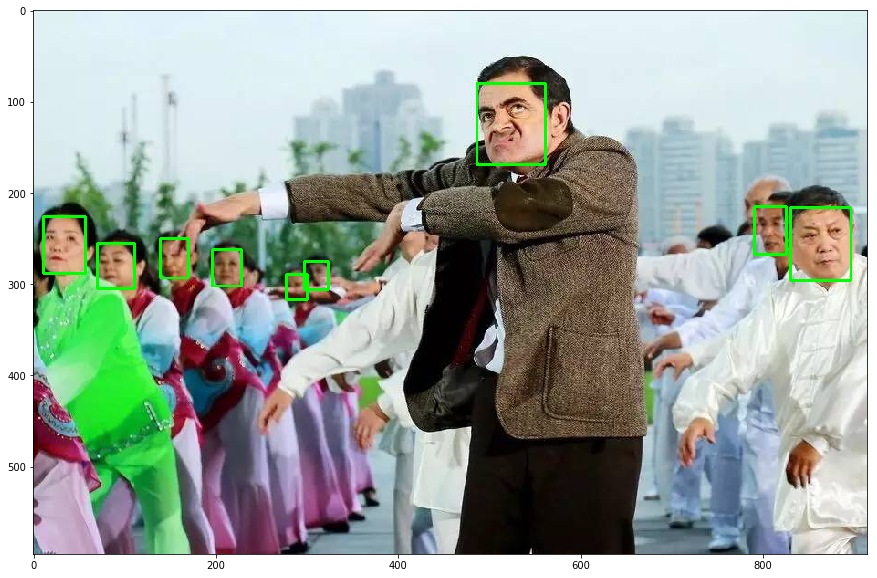

In [10]:
# copy the original image
draw = bgr_image.copy()

# the number of detected faces
faces_detected = len(bounding_boxes)

print('Total faces detected ：{}'.format(faces_detected))

# save the cropped faces
crop_faces=[]

# each bounding_box includes（x1,y1,x2,y2,confidence score)：
# 　　the coordinate of upper left corner (x1,y1)
#     the coordinate of lower right corner (x2,y2)
#     confidence score

# use for loop for each detected faces
for face_position in bounding_boxes:
    # convert the format of data from float to int
    face_position=face_position.astype(int)
    
    # extract the coordinate of the upper left corner (x1,y1)and lower right corner (x2,y2)
    # the value maybe be negative because the face is near the margin of the image
    # if the value is negative, set the value to 0
    x1 = face_position[0] if face_position[0] > 0 else 0
    y1 = face_position[1] if face_position[1] > 0 else 0
    x2 = face_position[2] if face_position[2] > 0 else 0
    y2 = face_position[3] if face_position[3] > 0 else 0
    
    # show the boundaries    
    cv2.rectangle(draw, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # crop the face images
    crop=bgr_image[y1:y2,x1:x2,]
    
    ### resize the sizes of the faces for other applicatins with other models (face recognition)
    # crop = cv2.resize(crop, (96, 96), interpolation=cv2.INTER_CUBIC )
    # crop_faces.append(crop)
    # plt.imshow(crop)
    # plt.show()

# set the size of figure
plt.figure(figsize=(20,10))

# show the result
# convert the image to RGB image, and use matplotlib to show it
plt.imshow(draw[:,:,::-1]) 
plt.show()

USing OpenCV Haar classifier, we only detect 4 faces of the image. 

Detect faces in the video.

In [5]:
# the path of the testing video
# the video is from Youtube: https://www.youtube.com/watch?v=aN862xUWt5I
video_inp =  os.path.join(TEST_VIDEOS_PATH, "dance.mp4")

# the output video
video_out =  os.path.join(TEST_VIDEOS_PATH, "dance_mtcnn.mp4")

# load the video wuth OpenCV
video_reader = cv2.VideoCapture(video_inp)

# the information of the video
nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT)) # the number of frames
frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))  # the height of each frame
frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))   # the width of each frame

# check the version of OpenCV
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

# check fps(frame per seconds) of the video
if int(major_ver)  < 3 :
    fps = video_reader.get(cv2.cv.CV_CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
else :
    fps = video_reader.get(cv2.CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))
        
# set the output video
video_writer = cv2.VideoWriter(video_out,
                               cv2.VideoWriter_fourcc(*'XVID'), 
                               fps, # set output fps
                               (frame_w, frame_h))
# the number of detected faces
total_faces_detected = 0

# use for loop for each frame in the video
for i in tqdm(range(nb_frames)):
    ret, bgr_image = video_reader.read() # read a frame
    
    # convert BGR image to RGB image
    rgb_image = bgr_image[:,:,::-1] 
    
    # face detection
    bounding_boxes, _ = detect_face.detect_face(rgb_image, minsize, pnet, rnet, onet, threshold, factor)
    
    # add the number of detected faces in this frame to the number of total detected faces in the video
    total_faces_detected += len(bounding_boxes) 
    
    # mark the boundaries of the detected faces in this fram
    for face_position in bounding_boxes:
        face_position=face_position.astype(int)
        #print(face_position[0:4])
        x1 = face_position[0] if face_position[0] > 0 else 0
        y1 = face_position[1] if face_position[1] > 0 else 0
        x2 = face_position[2] if face_position[2] > 0 else 0
        y2 = face_position[3] if face_position[3] > 0 else 0
            
        # use OpenCV to mark the boundary of detected face       
        cv2.rectangle(bgr_image, (x1, y1), (x2, y2), (0,255,0), 2)
        
    # use OpenCV to show the result
    video_writer.write(bgr_image)
    
video_reader.release() # release resource
video_writer.release() # release resource

print("Total faces detected: ", total_faces_detected)

Frames per second using video.get(cv2.CAP_PROP_FPS) : 29.97002997002997


100%|██████████████████████████████████████████████████████████████████████████████| 5263/5263 [19:47<00:00,  4.43it/s]


Total faces detected:  41903


Show the video after face detection.  
I upload the video to Youtube, and now insert the video from Youtube.

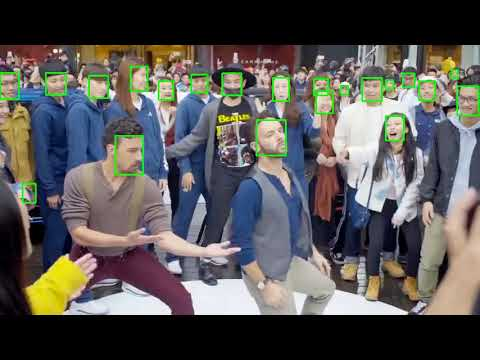

In [6]:
#show the video from Youtube
from IPython.lib.display import YouTubeVideo
YouTubeVideo('IqKT_vfX4eQ')